In [2]:
##!pip install protobuf==3.20.*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [2]:
# Load Data
train_df = pd.read_csv("D:/Projects/Sign language Detection/sign_mnist_train.csv")
test_df = pd.read_csv("D:/Projects/Sign language Detection/sign_mnist_test.csv")

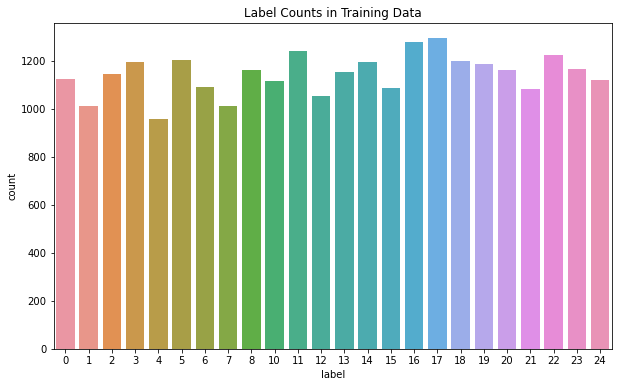

In [3]:
# Visualize label distribution (optional)
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train_df)
plt.title("Label Counts in Training Data")
plt.show()

In [4]:
# Separate features and labels
y_train = train_df['label']
y_test = test_df['label']
x_train = train_df.drop('label', axis=1).values
x_test = test_df.drop('label', axis=1).values

In [5]:
# One-hot encode labels
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.transform(y_test)

In [6]:
# Normalize pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0

In [7]:
# Reshape for CNN input
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [8]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(x_train)

In [9]:
# Model architecture
model = Sequential([
    Conv2D(75, (3,3), activation='relu', padding='same', input_shape=(28,28,1)),
    BatchNormalization(),
    MaxPool2D((2,2), padding='same'),
    Conv2D(50, (3,3), activation='relu', padding='same'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D((2,2), padding='same'),
    Conv2D(25, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D((2,2), padding='same'),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(24, activation='softmax')
])

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 75)       300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 50)       2

In [11]:
# Learning rate reduction callback
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.5, min_lr=1e-5, verbose=1)

In [12]:
# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=128),
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[lr_reduction]
)

Epoch 1/20
215/215 [==============================] - 74s 329ms/step - loss: 1.0636 - accuracy: 0.6675 - val_loss: 3.4649 - val_accuracy: 0.1578 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 74s 343ms/step - loss: 0.2170 - accuracy: 0.9265 - val_loss: 1.4643 - val_accuracy: 0.5549 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 44s 206ms/step - loss: 0.1046 - accuracy: 0.9659 - val_loss: 0.0551 - val_accuracy: 0.9847 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 84s 391ms/step - loss: 0.0645 - accuracy: 0.9795 - val_loss: 0.0499 - val_accuracy: 0.9852 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - 91s 422ms/step - loss: 0.0478 - accuracy: 0.9852 - val_loss: 0.0164 - val_accuracy: 0.9950 - lr: 0.0010
Epoch 6/20
215/215 [==============================] - 86s 402ms/step - loss: 0.0370 - accuracy: 0.9880 - val_loss: 0.1111 - val_accuracy: 0.9635 - lr: 0.0010
Epoch 7/20
215/215 [==============================] 

In [13]:
# Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

225/225 [==============================] - 5s 22ms/step - loss: 0.0011 - accuracy: 0.9997
Test Accuracy: 99.97%


In [14]:
# Save the model
model.save('smnist.h5')

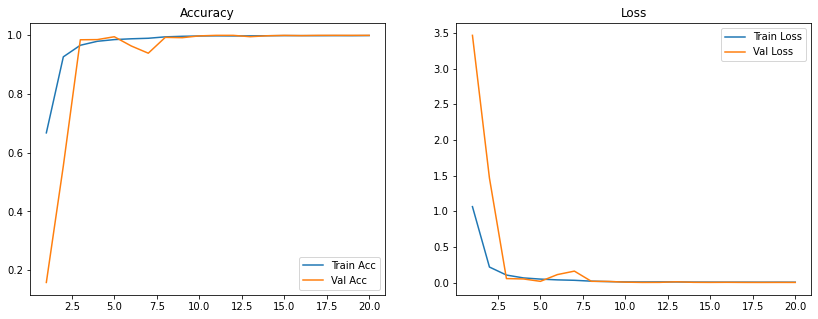

In [15]:
# Plot accuracy and loss
epochs = range(1, 21)
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(epochs, history.history['accuracy'], label='Train Acc')
plt.plot(epochs, history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, history.history['loss'], label='Train Loss')
plt.plot(epochs, history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()